In [114]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16

from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam

from PIL import Image 
import matplotlib.pyplot as plt

%matplotlib inline

In [115]:
LANDSCAPE_TYPE = 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'

# configurar de acuerdo a dónde bajaron los sets de imágenes
TRAIN_DIR = Path('./ucse-ia-2024-tp-2-clasificacion-de-imagenes/train')
TEST_DIR = Path('./ucse-ia-2024-tp-2-clasificacion-de-imagenes/test')

SIZE = 32

In [116]:
images_reader = ImageDataGenerator(
    rescale=1/255,  # Normaliza los píxeles a valores entre 0 y 1
    rotation_range=20,  # Rotar imágenes aleatoriamente entre 0 y 20 grados
    width_shift_range=0.2,  # Desplazar horizontalmente hasta el 20% del ancho
    height_shift_range=0.2,  # Desplazar verticalmente hasta el 20% de la altura
    shear_range=0.2,  # Cortar (shear) imágenes aleatoriamente
    zoom_range=0.2,  # Ampliar imágenes aleatoriamente
    horizontal_flip=True,  # Voltear imágenes horizontalmente
    fill_mode='nearest',  # Estrategia para rellenar nuevos píxeles
    brightness_range=(0.5, 1.5),  # Cambiar brillo aleatoriamente
    validation_split=0.2  # Porcentaje para la validación (40%)
)

READ_PARAMS = dict(
    class_mode="categorical",
    classes=LANDSCAPE_TYPE, # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE), # para que corra más rápido, vamos a achicar las imágenes
    color_mode="rgb",  # queremos trabajar con las imágenes a color
    batch_size=32, # Tamaño del lote
)

In [117]:
# Obtener los nombres de archivos en el directorio de prueba
test_dir = Path('./ucse-ia-2024-tp-2-clasificacion-de-imagenes/test')
filenames = [f.name for f in test_dir.iterdir() if f.is_file()]
filepaths = [str(test_dir / fname) for fname in filenames]

# Crear el DataFrame
test_df = pd.DataFrame({
    'filename': filenames,
    'filepath': filepaths
})

test = images_reader.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',    # La columna con las rutas de archivo completas
    y_col=None,          # No hay etiquetas en el conjunto de prueba
    target_size=(SIZE, SIZE),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 3000 validated image filenames.


In [118]:
# Generador para entrenamiento (80%)
train = images_reader.flow_from_directory(
    TRAIN_DIR,
    subset='training',
    **READ_PARAMS
)

# Generador para validación (40%)
validation = images_reader.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
    **READ_PARAMS
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [119]:
def sample_images_train(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(LANDSCAPE_TYPE[np.argmax(labels[i])])
        plt.axis("off")

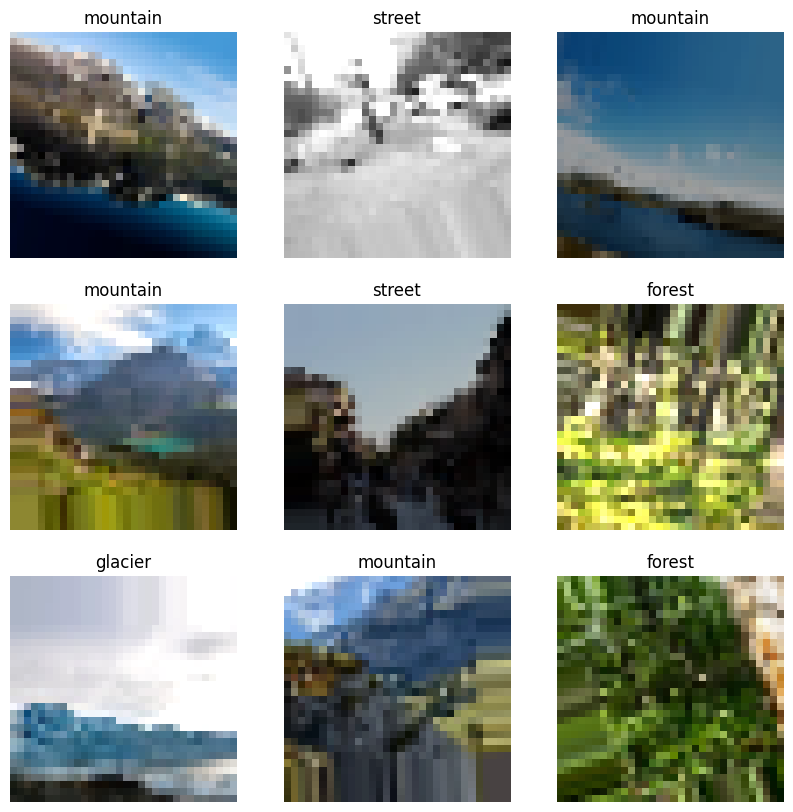

In [120]:
sample_images_train(train)

# 1 Análisis exploratorio sobre el conjunto de datos

## 1.1 Volumetría de los datos

In [121]:
def count_images_by_category(dataset_dir):
    categories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    category_counts = {}

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        image_files = [f for f in os.listdir(category_path) if f.endswith(('jpg', 'jpeg', 'png'))]
        category_counts[category] = len(image_files)

    total_images = sum(category_counts.values())

    return category_counts, total_images

# Obtener la volumetría de los datos
category_counts, total_images = count_images_by_category(TRAIN_DIR)

print("Volumetría del dataset:")
print(f"Total de imágenes: {total_images}")
for category, count in category_counts.items():
    print(f"{category}: {count} imágenes")

Volumetría del dataset:
Total de imágenes: 14034
forest: 2271 imágenes
buildings: 2191 imágenes
glacier: 2404 imágenes
street: 2382 imágenes
mountain: 2512 imágenes
sea: 2274 imágenes


## 1.2 Estructura y tipo de las imágenes

In [122]:
def get_image_dimensions(dataset_dir):
    image_dimensions = []
    image_formats = []
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                image_dimensions.append(img.size)  # Obtiene el tamaño (ancho, alto)
                image_formats.append(img.format)  # Obtiene el formato de la imagen
    
    return image_dimensions, image_formats

# Obtener la estructura de las imágenes
image_dimensions, image_formats = get_image_dimensions(TRAIN_DIR)

# Muestra algunos ejemplos de dimensiones y formatos
print("Ejemplos de dimensiones de imágenes:")
for i in range(5):
    print(f"Imagen {i+1}: {image_dimensions[i]} (Formato: {image_formats[i]})")


Ejemplos de dimensiones de imágenes:
Imagen 1: (150, 150) (Formato: JPEG)
Imagen 2: (150, 150) (Formato: JPEG)
Imagen 3: (150, 150) (Formato: JPEG)
Imagen 4: (150, 150) (Formato: JPEG)
Imagen 5: (150, 150) (Formato: JPEG)


## 1.3 Distribución de la variable a predecir

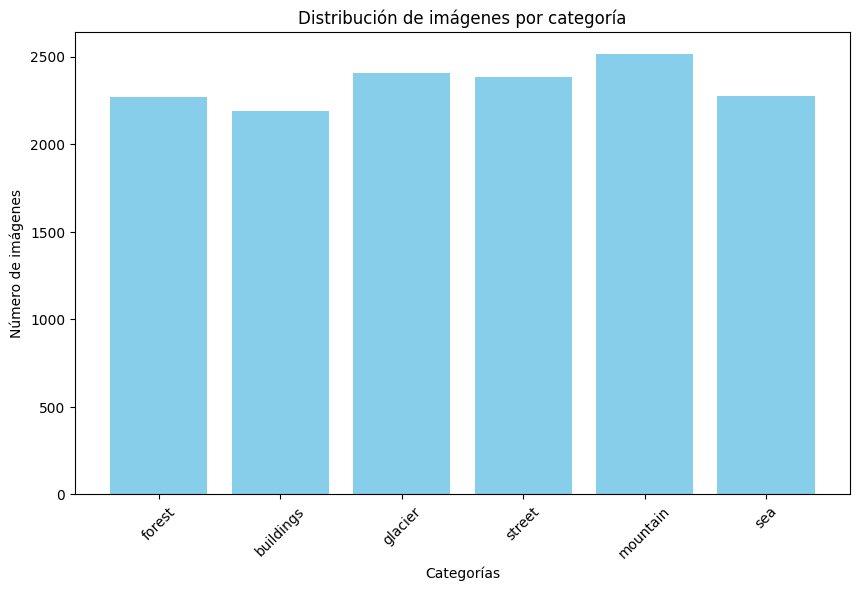

In [123]:
def plot_image_distribution(category_counts):
    categories = list(category_counts.keys())
    counts = list(category_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Categorías')
    plt.ylabel('Número de imágenes')
    plt.title('Distribución de imágenes por categoría')
    plt.xticks(rotation=45)
    plt.show()

# Graficar la distribución de las imágenes por categoría
plot_image_distribution(category_counts)

# 2 Modelado

In [126]:
# UTILS

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

# Función para plotear el historial de entrenamiento
def PlotHistory(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title('Accuracy over train epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

class MLPBuilder:
    def __init__(
        self, 
        input_shape=(SIZE, SIZE, 3), 
        output_size=len(LANDSCAPE_TYPE),
    ):
        self.input_shape = input_shape  # Ej: (SIZE, SIZE, 3)
        self.output_size = output_size  # Ej: len(LANDSCAPE_TYPE)
        self.model = None
    
    def build_model(self, layers_config, batch_normalization=False):
        """
        Construye un modelo secuencial MLP basado en la configuración proporcionada.

        :param layers_config: Lista de diccionarios con la configuración de cada capa. 
                              Ej: [{'units': 1024, 'activation': 'tanh', 'dropout': 0.25}, {...}]
        """
        self.model = Sequential()
        
        # Primera capa: Flatten (Aplanar las imágenes)
        self.model.add(Flatten(input_shape=self.input_shape))
        
        # Agregar capas ocultas configuradas
        for layer in layers_config:            
            if layer['activation'] == 'leakyrelu':
                self.model.add(Dense(layer['units']))
                self.model.add(LeakyReLU(alpha=0.01))
            else:
                self.model.add(Dense(layer['units'], activation=layer['activation']))

            if batch_normalization:
                self.model.add(BatchNormalization())

            if 'dropout' in layer:
                self.model.add(Dropout(layer['dropout']))
        
        # Capa de salida (softmax para clasificación multiclase)
        self.model.add(Dense(self.output_size, activation='softmax'))

    def compile_model(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        """
        Compila el modelo con el optimizador, la función de pérdida y las métricas indicadas.
        """
        if self.model:
            self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            self.model.summary()
        else:
            raise ValueError("El modelo no está construido. Llama a build_model primero.")
    
    def get_model(self):
        """
        Devuelve el modelo generado.
        """
        return self.model

    def fit_model(self, train=train, validation=validation, epochs=30, batch_size=32, callbacks=[OurCustomCallback()]):
        """
        Entrena el modelo con 30 épocas por default.
        """
        print(f"{epochs}: epochs")
        return PlotHistory(self.model.fit(
            train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation,
            callbacks=callbacks,
        ))

## Modelo MLP 1024 - 512 - 256

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_36 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,804,422 (14.51 MB)

 Trainable params: 3,804,422 (14.51 MB)

 Non-trainable params: 0 (0.00 B)

30: epochs
Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.2771 - loss: 1.8973 - val_accuracy: 0.4194 - val_loss: 1.4590
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.4018 - loss: 1.5112 - val_accuracy: 0.4383 - val_loss: 1.4184
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.4234 - loss: 1.4508 - val_accuracy: 0.4900 - val_loss: 1.3586
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.4336 - loss: 1.4102 - val_accuracy: 0.4757 - val_loss: 1.3476
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.4670 - loss: 1.3685 - val_accuracy: 0.4971 - val_loss: 1.3217
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.4642 - loss: 1.3672 - val_accuracy: 0.5118 - val_loss: 1.2894
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.4675 - loss: 1.3725 - val_accuracy: 0.5150 - val_loss: 1.2825
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.4803 - loss

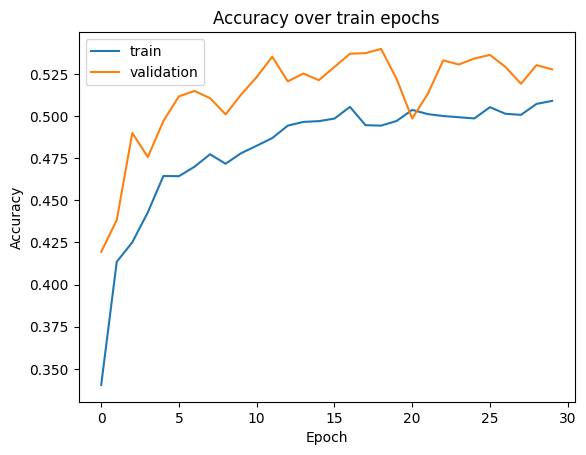

In [127]:
# Configuración de capas del MLP
layers_config = [
    {'units': 1024, 'activation': 'relu', 'dropout': 0.25},
    {'units': 512, 'activation': 'relu', 'dropout': 0.25},
    {'units': 256, 'activation': 'relu', 'dropout': 0.25}
]

mlp_mode_1024_512_256 = MLPBuilder()
mlp_mode_1024_512_256.build_model(layers_config)
mlp_mode_1024_512_256.compile_model()
mlp_mode_1024_512_256.fit_model()

### Conclusiones

Este primer modelo MLP que probamos no está alcanzando una buena precisión, tanto en el conjunto de entrenamiento como en el de validación. La precisión se mantiene baja (~0.26) y la pérdida es relativamente alta. 

El número de neuronas (1024, 512, 256) podría ser demasiado grande para el problema. Vamos a reducirlas para evitar el sobreajuste, dado que el modelo parece estar teniendo dificultades para generalizar.



## Modelo MLP 256 - 128

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_37 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 820,358 (3.13 MB)

 Trainable params: 820,358 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

30: epochs
Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.2656 - loss: 1.8077 - val_accuracy: 0.3959 - val_loss: 1.5217
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.3879 - loss: 1.5067 - val_accuracy: 0.3894 - val_loss: 1.5081
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.4038 - loss: 1.4693 - val_accuracy: 0.4815 - val_loss: 1.3590
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.4302 - loss: 1.4354 - val_accuracy: 0.4964 - val_loss: 1.3449
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.4468 - loss: 1.3987 - val_accuracy: 0.4711 - val_loss: 1.3876
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.4403 - loss: 1.3951 - val_accuracy: 0.4950 - val_loss: 1.3318
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.4554 - loss: 1.3761 - val_accuracy: 0.4982 - val_loss: 1.3374
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.4595 - loss

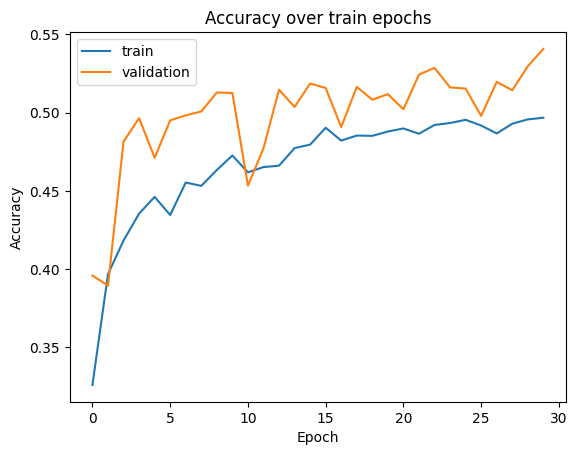

In [128]:
# Configuración de capas del MLP
layers_config = [
    {'units': 256, 'activation': 'relu', 'dropout': 0.25},
    {'units': 128, 'activation': 'relu', 'dropout': 0.25},
]

mlp_model_256_128_relu = MLPBuilder()
mlp_model_256_128_relu.build_model(layers_config)
mlp_model_256_128_relu.compile_model()
mlp_model_256_128_relu.fit_model()

### Variante del modelo MLP 256 - 128 con menos porcentaje de dropout

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_38 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 820,358 (3.13 MB)

 Trainable params: 820,358 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

30: epochs
Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.3258 - loss: 1.7105 - val_accuracy: 0.4387 - val_loss: 1.4243
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.4387 - loss: 1.4177 - val_accuracy: 0.4911 - val_loss: 1.3080
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.4614 - loss: 1.3691 - val_accuracy: 0.4718 - val_loss: 1.3266
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.4819 - loss: 1.3406 - val_accuracy: 0.4772 - val_loss: 1.3155
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.4779 - loss: 1.3351 - val_accuracy: 0.5125 - val_loss: 1.2487
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.4887 - loss: 1.3103 - val_accuracy: 0.5086 - val_loss: 1.2651
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.5063 - loss: 1.2817 - val_accuracy: 0.5207 - val_loss: 1.2641
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.4985 - loss

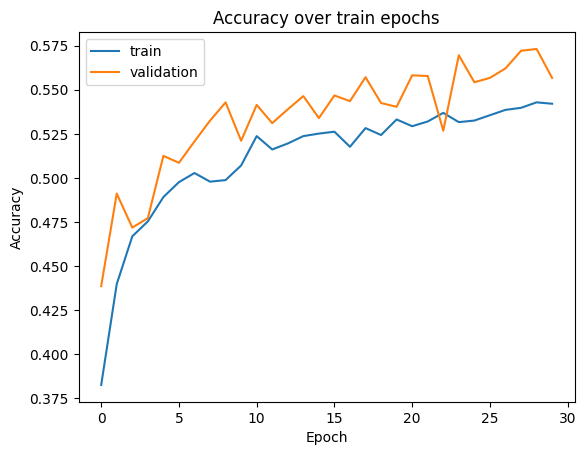

In [129]:
# Configuración de capas del MLP
layers_config = [
    {'units': 256, 'activation': 'relu', 'dropout': 0.10},
    {'units': 128, 'activation': 'relu', 'dropout': 0.10},
]

mlp_model_256_128_0_10_relu = MLPBuilder()
mlp_model_256_128_0_10_relu.build_model(layers_config)
mlp_model_256_128_0_10_relu.compile_model()
mlp_model_256_128_0_10_relu.fit_model()

## Modelo MLP 128 - 64

In [130]:
# Nueva Configuración de Capas del MLP
layers_config = [
    {'units': 128, 'activation': 'tanh', 'dropout': 0.15},
    {'units': 64, 'activation': 'tanh', 'dropout': 0.15},
]

mlp_model_128_64_0_15_tanh = MLPBuilder()
mlp_model_128_64_0_15_tanh.build_model(layers_config)
mlp_model_128_64_0_15_tanh.compile_model()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_39 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401,990 (1.53 MB)

 Trainable params: 401,990 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

### Conclusiones

El nuevo modelo simplificado muestra una mejora en la precisión, aunque sigue habiendo espacio para optimizarlo. Actualmente, la precisión en el conjunto de validación se estabiliza entre un 30% y 35%, lo que indica que el modelo aún no está capturando de manera efectiva todas las características del conjunto de datos. Se puede observar que en la época 8 el modelo alcanza su límite de rendimiento, comenzando a presentar signos de sobreajuste.

## Modelo MLP con LeakyReLU y Batch Normalization

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_40 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_99 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_142 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_100 (LeakyReLU)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,894 (3.14 MB)

 Trainable params: 821,126 (3.13 MB)

 Non-trainable params: 768 (3.00 KB)

30: epochs
Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.3749 - loss: 1.6743 - val_accuracy: 0.3866 - val_loss: 1.6686
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.4443 - loss: 1.4254 - val_accuracy: 0.4290 - val_loss: 1.4307
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.4735 - loss: 1.3679 - val_accuracy: 0.4561 - val_loss: 1.3645
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.4834 - loss: 1.3388 - val_accuracy: 0.4501 - val_loss: 1.4096
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.4948 - loss: 1.3162 - val_accuracy: 0.4490 - val_loss: 1.3533
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.5030 - loss: 1.2878 - val_accuracy: 0.5278 - val_loss: 1.2456
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.5083 - loss: 1.2741 - val_accuracy: 0.5107 - val_loss: 1.2727
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.5068 - loss

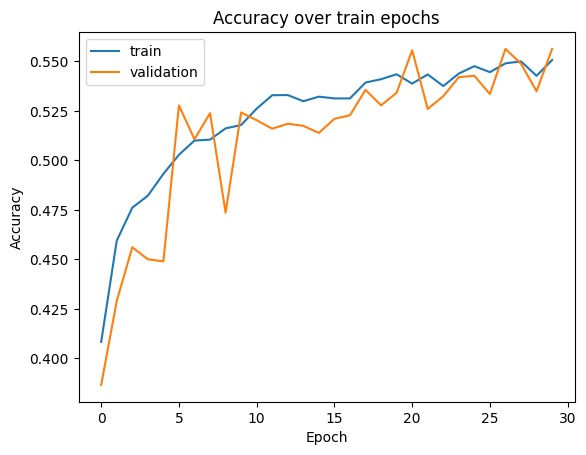

In [131]:
layers_config = [
    {'units': 256, 'activation': 'leakyrelu', 'dropout': 0.15},
    {'units': 128, 'activation': 'leakyrelu', 'dropout': 0.15},
]

mlp_model_128_64_0_15_leakyrelu = MLPBuilder()
mlp_model_128_64_0_15_leakyrelu.build_model(layers_config, batch_normalization=True)
mlp_model_128_64_0_15_leakyrelu.compile_model()
mlp_model_128_64_0_15_leakyrelu.fit_model()

# Convolucional

In [132]:
class Convolucional:
    def __init__(self, config):
        self.model = self.build_model(config)
        self.compile_model()

    def build_model(self, config):
        model = Sequential(config)
        model.summary()
        return model

    def compile_model(self, learning_rate=0.001):
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def fit(self, train_data=train, validation_data=validation, epochs=50, batch_size=64, callbacks=None):
        return PlotHistory(self.model.fit(
            train_data,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation_data,
            callbacks=callbacks
        ))


## Modelo convolucional 1

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_91 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_101 (LeakyReLU)     │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_102 (LeakyReLU)     │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_103 (LeakyReLU)     │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_146 (Dropout)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_109         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_104 (LeakyReLU)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 554,854 (2.12 MB)

 Trainable params: 554,342 (2.11 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 37s 99ms/step - accuracy: 0.4355 - loss: 1.5096 - val_accuracy: 0.3645 - val_loss: 1.7783
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - accuracy: 0.5611 - loss: 1.1111 - val_accuracy: 0.6348 - val_loss: 0.9692
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.6018 - loss: 1.0337 - val_accuracy: 0.5813 - val_loss: 1.0764
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.6176 - loss: 1.0008 - val_accuracy: 0.5267 - val_loss: 1.3224
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step - accuracy: 0.6532 - loss: 0.9210 - val_accuracy: 0.6330 - val_loss: 0.9434
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step - accuracy: 0.6502 - loss: 0.9121 - val_accuracy: 0.6451 - val_loss: 0.9711
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.6662 - loss: 0.8847 - val_accuracy: 0.6876 - val_loss: 0.8193
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.6937 - loss: 0.8

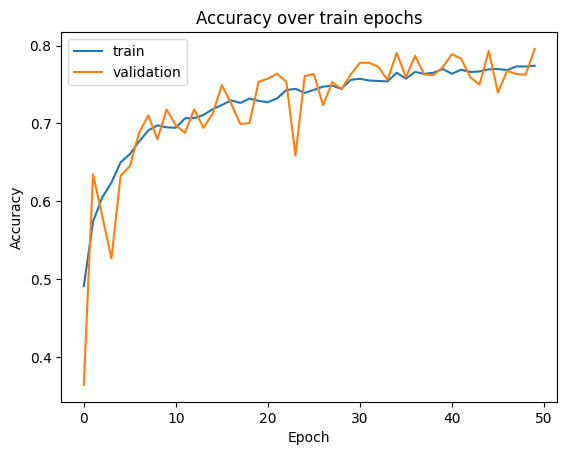

In [133]:
config=[
    Input(shape=(SIZE, SIZE, 3)),

    Convolution2D(filters=32, kernel_size=(3, 3), strides=1, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.25),

    Convolution2D(filters=32, kernel_size=(3, 3), strides=1, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Convolution2D(filters=64, kernel_size=(3, 3), strides=1, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    
    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(len(LANDSCAPE_TYPE), activation='softmax'),
]

LeNetX64_batchNorm_dropout = Convolucional(config=config)

LeNetX64_batchNorm_dropout.fit()

## Modelo convolucional 2

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_110         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_105 (LeakyReLU)     │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_106 (LeakyReLU)     │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_107 (LeakyReLU)     │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_150 (Dropout)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_42 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_108 (LeakyReLU)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,213,574 (8.44 MB)

 Trainable params: 2,212,550 (8.44 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 227ms/step - accuracy: 0.4729 - loss: 1.4484 - val_accuracy: 0.3163 - val_loss: 1.8907
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 229ms/step - accuracy: 0.5777 - loss: 1.0642 - val_accuracy: 0.5827 - val_loss: 1.0991
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 226ms/step - accuracy: 0.6089 - loss: 1.0036 - val_accuracy: 0.6205 - val_loss: 0.9759
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.6504 - loss: 0.9230 - val_accuracy: 0.6427 - val_loss: 0.9728
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 223ms/step - accuracy: 0.6697 - loss: 0.8729 - val_accuracy: 0.6616 - val_loss: 0.8752
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 221ms/step - accuracy: 0.6615 - loss: 0.8710 - val_accuracy: 0.6904 - val_loss: 0.8456
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 221ms/step - accuracy: 0.6823 - loss: 0.8397 - val_accuracy: 0.6427 - val_loss: 0.9954
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 242ms/step - accuracy: 0.6952 - loss: 0

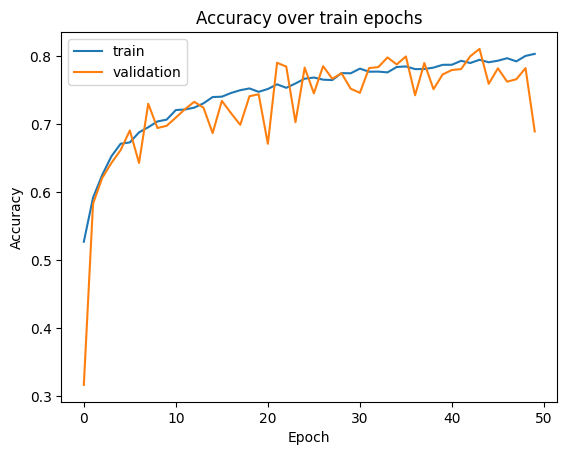

In [134]:
config=[
    Input(shape=(SIZE, SIZE, 3)),

    Convolution2D(filters=64, kernel_size=(3, 3), strides=1, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Convolution2D(filters=64, kernel_size=(3, 3), strides=1, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Convolution2D(filters=128, kernel_size=(3, 3), strides=1, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    
    Dense(256),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(len(LANDSCAPE_TYPE), activation='softmax'),
]

AdvancedConvNet_64x128 = Convolucional(config=config)

AdvancedConvNet_64x128.fit()

# Pruebas para predecir

In [142]:
from IPython.display import Image, display

def show_and_predict(image_path):
    image_array = img_to_array(load_img(image_path, target_size=(SIZE, SIZE)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = AdvancedConvNet_64x128.model.predict(inputs)
    display(Image(image_path, width=500))
    print("Prediction:", LANDSCAPE_TYPE[np.argmax(predictions)])
    print("Prediction detail:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


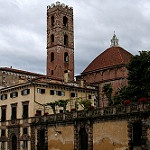

Prediction: buildings
Prediction detail: [[1. 0. 0. 0. 0. 0.]]


In [143]:
images = ["./20056.jpg","./20057.jpg","./20058.jpg","./20059.jpg","./20056.jpg","./20056.jpg","./20056.jpg"]
show_and_predict("./20061.jpg")

# Generar submission para la competencia de kaggle

In [50]:
# Nos quedamos con el modelo AdvancedConvNet_64x128
# Generar predicciones con el modelo entrenado
predictions = AdvancedConvNet_64x128.predict(test)

# Obtener las etiquetas de las clases
class_indices = train.class_indices # Me traigo las clases de train porque ahí las tengo disponibles
class_names = list(class_indices.keys())

# Convertir las predicciones a etiquetas
predicted_labels = [class_names[np.argmax(pred)] for pred in predictions]

# Extraer los nombres de archivo (IDs) de test_generator
ids = [filename.split('/')[-1] for filename in test.filenames]

# Crear el DataFrame con IDs y etiquetas predichas
submission_df = pd.DataFrame({
    'ID': ids,
    'Label': predicted_labels
})

# Guardar el archivo CSV en el formato solicitado
submission_df.to_csv('submission.csv', index=False)

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step


# Modelos pre-entrenados

In [22]:
from keras.applications import VGG16, ResNet50, InceptionV3, DenseNet121, MobileNetV2, EfficientNetB0

class CustomPretrainedModel:
    def __init__(self, model_name, custom_layers, num_classes=len(LANDSCAPE_TYPE), input_size=(SIZE, SIZE, 3)):
        """
        Inicializa el modelo pre-entrenado elegido con capas personalizadas.

        Args:
            model_name (str): Nombre del modelo a utilizar ('vgg16', 'resnet50', 'inceptionv3', 
                              'densenet121', 'mobilenetv2', 'efficientnetb0').
            custom_layer (int): Número de neuronas en la capa densa personalizada.
            num_classes (int): Número de clases para la clasificación.
            input_size (tuple): Tamaño de la entrada (altura, ancho, canales).
        """
        self.model_name = model_name
        self.num_classes = num_classes
        self.input_size = input_size
        self.model = self.build_model(custom_layers)

    def build_model(self, custom_layers):
        """
        Construye el modelo pre-entrenado seleccionado con capas personalizadas.

        Returns:
            keras.Model: Modelo con capas personalizadas.
        """
  
        base_model_dict = {
            'vgg16': VGG16,
            'resnet50': ResNet50,
            'inceptionv3': InceptionV3,
            'densenet121': DenseNet121,
            'mobilenetv2': MobileNetV2,
            'efficientnetb0': EfficientNetB0
        }

        # Seleccionar el modelo base según el nombre proporcionado
        model_class = base_model_dict.get(self.model_name.lower())
        
        base_model = model_class(weights='imagenet', include_top=False, input_shape=self.input_size)

        if model_class is None:
            raise ValueError(f"Modelo {self.model_name} no es válido. Elige entre: {', '.join(base_model_dict.keys())}")


        # Congelar las capas del modelo base
        for layer in base_model.layers:
            layer.trainable = False

        # Añadir las capas personalizadas al final del modelo
        x = base_model.output
        x = Flatten()(x)
        x = Dense(custom_layers, activation='relu')(x)  # Capa densa personalizada
        x = Dense(self.num_classes, activation='softmax')(x)  # Capa de salida para clasificación

        # Crear el modelo final
        model = Model(inputs=base_model.input, outputs=x)
        return model

    def compile_model(self, learning_rate=0.001):
        """
        Compila el modelo con el optimizador y la función de pérdida.

        Args:
            learning_rate (float): Tasa de aprendizaje para el optimizador.
        """
        self.model.compile(optimizer=Adam(learning_rate=learning_rate),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
        self.model.summary()

    def get_model(self):
        """
        Devuelve el modelo compilado.

        Returns:
            keras.Model: Modelo compilado.
        """
        return self.model

    def fit_model(self, train=train, epochs=15, validation_data=validation):
        """
        Entrena el modelo utilizando los datos proporcionados.
        Args:
            epochs (int): Número de épocas para entrenar.
        """
        return PlotHistory(self.model.fit(train, epochs=epochs, validation_data=validation_data))

Entrenando modelo: vgg16 con 64 capas personalizadas


Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,010,054 (57.26 MB)

 Trainable params: 295,366 (1.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.6479 - loss: 0.9196 - val_accuracy: 0.7832 - val_loss: 0.5985
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.7701 - loss: 0.5917 - val_accuracy: 0.7934 - val_loss: 0.5784
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.7986 - loss: 0.5565 - val_accuracy: 0.7925 - val_loss: 0.5530
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.8013 - loss: 0.5366 - val_accuracy: 0.7722 - val_loss: 0.6163
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.8061 - loss: 0.5104 - val_accuracy: 0.7941 - val_loss: 0.5495
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.8175 - loss: 0.4849 - val_accuracy: 0.8034 - val_loss: 0.5206
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.8218 - loss: 0.4742 - val_accuracy: 0.8094 - val_loss: 0.5321
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.8125 - loss: 0.4980 - val_accu

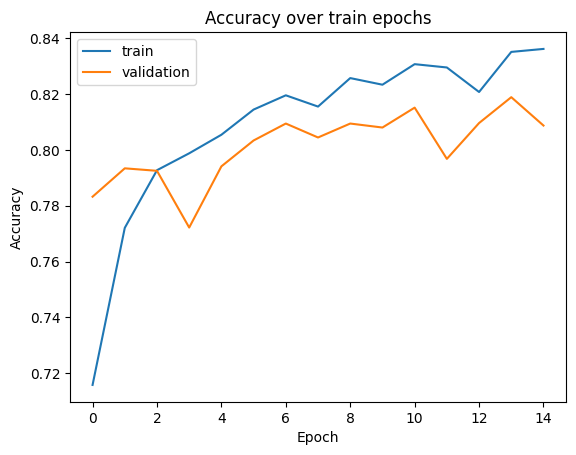

Entrenando modelo: resnet50 con 64 capas personalizadas


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_3_c

 Total params: 25,685,318 (97.98 MB)

 Trainable params: 2,097,606 (8.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 202s 743ms/step - accuracy: 0.1725 - loss: 2.1711 - val_accuracy: 0.1790 - val_loss: 1.7913
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 194s 732ms/step - accuracy: 0.1802 - loss: 1.7977 - val_accuracy: 0.1790 - val_loss: 1.7909
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 193s 726ms/step - accuracy: 0.1813 - loss: 1.7902 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 194s 731ms/step - accuracy: 0.1864 - loss: 1.7904 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 194s 733ms/step - accuracy: 0.1789 - loss: 1.7967 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 196s 740ms/step - accuracy: 0.1815 - loss: 1.7902 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 196s 738ms/step - accuracy: 0.1747 - loss: 1.7902 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 194s 732ms/step - accuracy: 0.1720 -

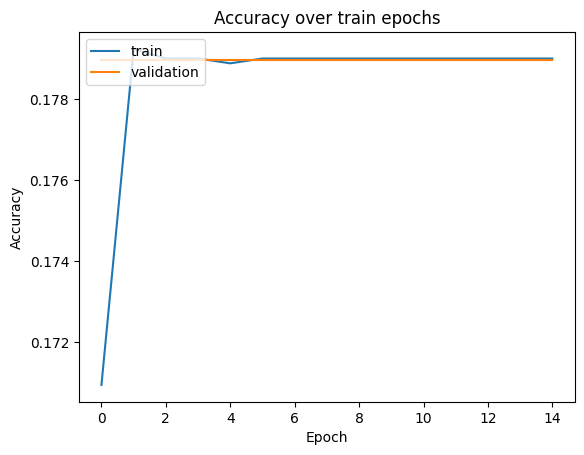

Entrenando modelo: inceptionv3 con 64 capas personalizadas
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 49, 49,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 49,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 49, 49,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 47, 47,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 47, 47,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 23, 23,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 23, 23,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 23,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 23, 23,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 21, 21,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 21, 21,    │          0 │ batch_normalizat

 Total params: 21,934,310 (83.67 MB)

 Trainable params: 131,526 (513.77 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 165s 600ms/step - accuracy: 0.5400 - loss: 1.2118 - val_accuracy: 0.7059 - val_loss: 0.8019
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 158s 594ms/step - accuracy: 0.7003 - loss: 0.8033 - val_accuracy: 0.7062 - val_loss: 0.7855
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 157s 591ms/step - accuracy: 0.7044 - loss: 0.7746 - val_accuracy: 0.7234 - val_loss: 0.7343
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 260s 980ms/step - accuracy: 0.7229 - loss: 0.7517 - val_accuracy: 0.7381 - val_loss: 0.7072
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.7341 - loss: 0.7130 - val_accuracy: 0.7390 - val_loss: 0.6876
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.7427 - loss: 0.7051 - val_accuracy: 0.7453 - val_loss: 0.6900
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 278s 992ms/step - accuracy: 0.7400 - loss: 0.6967 - val_accuracy: 0.7333 - val_loss: 0.6868
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.7471 - loss: 0.

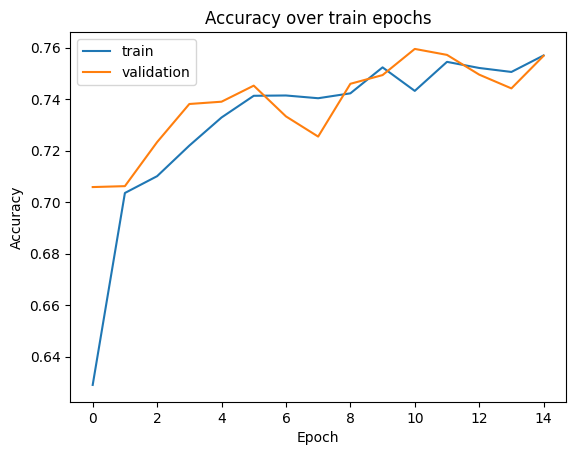

Entrenando modelo: densenet121 con 64 capas personalizadas
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 106, 106,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 25, 25,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 25, 25,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 25, 25,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 25, 25,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 25, 25,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 25, 25,    │     12,288 │ conv2_block2_0_r

 Total params: 7,627,782 (29.10 MB)

 Trainable params: 590,278 (2.25 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 201s 714ms/step - accuracy: 0.6888 - loss: 0.9937 - val_accuracy: 0.8082 - val_loss: 0.5279
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 191s 724ms/step - accuracy: 0.8322 - loss: 0.4794 - val_accuracy: 0.8228 - val_loss: 0.4979
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 179s 675ms/step - accuracy: 0.8401 - loss: 0.4456 - val_accuracy: 0.8449 - val_loss: 0.4230
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 178s 674ms/step - accuracy: 0.8453 - loss: 0.4185 - val_accuracy: 0.8442 - val_loss: 0.4406
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 189s 715ms/step - accuracy: 0.8470 - loss: 0.4106 - val_accuracy: 0.8487 - val_loss: 0.4343
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 175s 660ms/step - accuracy: 0.8541 - loss: 0.3829 - val_accuracy: 0.8460 - val_loss: 0.4177
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 166s 628ms/step - accuracy: 0.8471 - loss: 0.4043 - val_accuracy: 0.8446 - val_loss: 0.4264
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 170s 641ms/step - accuracy: 0.8550 -

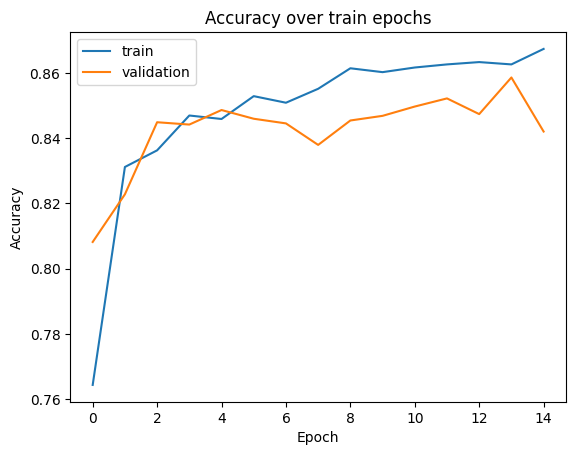

Entrenando modelo: mobilenetv2 con 64 capas personalizadas


/var/folders/j2/v0jwr_xj52d6wqq0xkm3dshw0000gn/T/ipykernel_45404/4287117977.py:40: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = model_class(weights='imagenet', include_top=False, input_shape=self.input_size)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 50, 50,    │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 50, 50,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 50, 50,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 50, 50,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 50, 50,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 50, 50,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 50, 50,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 50, 50,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 51, 51,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 25, 25,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 25, 25,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 25, 25,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 25, 25,    │      2,304 │ block_1_depthwis

 Total params: 3,569,158 (13.62 MB)

 Trainable params: 1,311,174 (5.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 70s 253ms/step - accuracy: 0.6028 - loss: 1.7033 - val_accuracy: 0.7920 - val_loss: 0.5844
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 66s 248ms/step - accuracy: 0.7889 - loss: 0.5933 - val_accuracy: 0.8132 - val_loss: 0.5473
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 66s 248ms/step - accuracy: 0.8155 - loss: 0.5223 - val_accuracy: 0.7996 - val_loss: 0.5583
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 65s 244ms/step - accuracy: 0.8240 - loss: 0.5041 - val_accuracy: 0.8162 - val_loss: 0.5119
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 67s 250ms/step - accuracy: 0.8393 - loss: 0.4554 - val_accuracy: 0.8212 - val_loss: 0.4928
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 66s 249ms/step - accuracy: 0.8485 - loss: 0.4420 - val_accuracy: 0.8365 - val_loss: 0.4604
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 67s 251ms/step - accuracy: 0.8447 - loss: 0.4278 - val_accuracy: 0.8360 - val_loss: 0.4584
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 68s 255ms/step - accuracy: 0.8326 - loss: 0

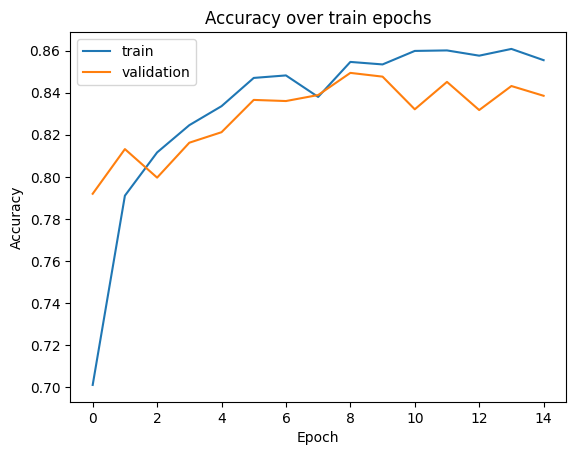

Entrenando modelo: efficientnetb0 con 64 capas personalizadas
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 100, 100,  │          0 │ input_layer_10[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 100, 100,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 100, 100,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 101, 101,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 50, 50,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 50, 50,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 50, 50,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 50, 50,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 50, 50,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 50, 50,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 50, 50,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 50, 50,    │        512 │ block1a_se_excit

 Total params: 5,360,745 (20.45 MB)

 Trainable params: 1,311,174 (5.00 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 163s 584ms/step - accuracy: 0.1719 - loss: 2.3336 - val_accuracy: 0.1713 - val_loss: 1.7913
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 157s 589ms/step - accuracy: 0.1799 - loss: 1.7913 - val_accuracy: 0.1790 - val_loss: 1.7909
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 158s 594ms/step - accuracy: 0.1787 - loss: 1.7908 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 4/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 158s 593ms/step - accuracy: 0.1747 - loss: 1.7910 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 5/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 157s 591ms/step - accuracy: 0.1789 - loss: 1.7905 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 6/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 19127s 73s/step - accuracy: 0.1882 - loss: 1.7902 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 7/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 151s 570ms/step - accuracy: 0.1759 - loss: 1.7905 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 8/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 153s 574ms/step - accuracy: 0.1823 -

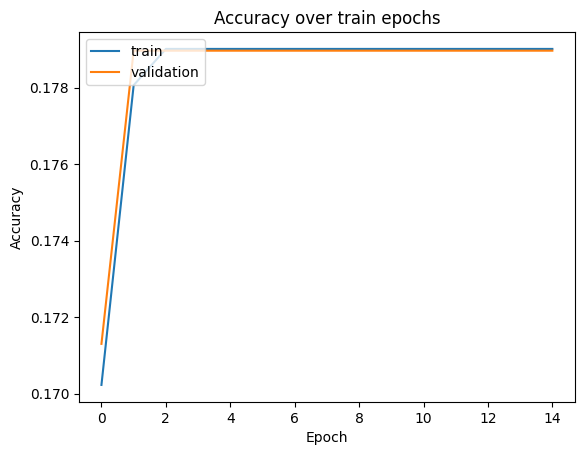

In [23]:
# Lista de modelos a probar junto con el número de capas personalizadas
model_names = [
    ('vgg16', 64),
    ('resnet50', 64),
    ('inceptionv3', 64),
    ('densenet121', 64),
    ('mobilenetv2', 64),
    ('efficientnetb0', 64)
]

# Entrenar cada modelo
for model_name, custom_layers in model_names:
    print(f"Entrenando modelo: {model_name} con {custom_layers} capas personalizadas")
    custom_model = CustomPretrainedModel(model_name=model_name, custom_layers=custom_layers)
    custom_model.compile_model()
    custom_model.fit_model()